## Predict values with nan in WineQuality dataset in "residual sugar" feature

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

In [ ]:
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')
df_orig = df.copy(deep=True)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Creating the Missing Data

In [ ]:
size_nan = 10
index_of_nan_values = np.random.choice(range(len(df)),size=size_nan)
df['residual sugar'][index_of_nan_values] = np.nan
index_of_not_nan_values = np.where(~df['residual sugar'].isna())[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
X_train = (df.drop(columns = ['residual sugar'])).values
X_train = X_train[index_of_not_nan_values,:]
y_train = (df['residual sugar']).values
y_train = torch.tensor(y_train[index_of_not_nan_values]).float().reshape(-1,1)


X_test = (df_orig.drop(columns=['residual sugar'])).values
X_test =  X_test[index_of_nan_values,:]
y_test = (df_orig['residual sugar']).values
y_test = torch.tensor(y_test[index_of_nan_values]).float().reshape(-1,1)

In [ ]:
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [ ]:
X_train = torch.tensor(X_train).float()
train_dataset = TensorDataset(X_train, y_train)
batchsize = 16
train_data = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)

X_test = torch.tensor(X_test).float()

## Creating the ANN model

In [ ]:
class ANN(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(11,16)

    self.hl1 = nn.Linear(16,32)
    self.hl2 = nn.Linear(32,32)

    self.output = nn.Linear(32,1)

  def forward(self,x):
    x = F.relu(self.input(x))
    x = F.relu(self.hl1(x))
    x = F.relu(self.hl2(x))
    return self.output(x)

In [ ]:
model = ANN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()

epochs = 150
train_loss = torch.zeros(epochs)

for i in range(epochs):
  batch_loss = []

  for X,y in train_data:
    predict = model(X)
    losses = loss(predict,y)
    

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    batch_loss.append(losses.item())
  print("epoch:", i , "loss", losses.item())
  train_loss[i] = np.mean(batch_loss)


epoch: 0 loss 1.3301441669464111
epoch: 1 loss 1.7813106775283813
epoch: 2 loss 0.562369704246521
epoch: 3 loss 0.7089887857437134
epoch: 4 loss 2.848877191543579
epoch: 5 loss 0.3315781354904175
epoch: 6 loss 4.5004706382751465
epoch: 7 loss 0.7107726335525513
epoch: 8 loss 0.2757009267807007
epoch: 9 loss 1.0457439422607422
epoch: 10 loss 0.29358407855033875
epoch: 11 loss 0.6543549299240112
epoch: 12 loss 0.5019442439079285
epoch: 13 loss 0.3092716336250305
epoch: 14 loss 0.48985299468040466
epoch: 15 loss 0.659442126750946
epoch: 16 loss 0.3965335190296173
epoch: 17 loss 0.9082911014556885
epoch: 18 loss 1.3606112003326416
epoch: 19 loss 0.5424599051475525
epoch: 20 loss 0.3379232585430145
epoch: 21 loss 0.5669828653335571
epoch: 22 loss 0.18526414036750793
epoch: 23 loss 0.643697202205658
epoch: 24 loss 0.23930177092552185
epoch: 25 loss 0.2768489420413971
epoch: 26 loss 0.1334233283996582
epoch: 27 loss 0.8400155305862427
epoch: 28 loss 0.3524955213069916
epoch: 29 loss 1.1953356

In [ ]:
print(train_loss[-1])

tensor(0.1754)


In [ ]:
train_predict = model(X_train)
test_predict = model(X_test)

In [ ]:
print(r2_score(y_test.detach(),test_predict.detach()))

0.9359260252458949


Text(0.5, 1.0, 'Model predictions vs. observations')

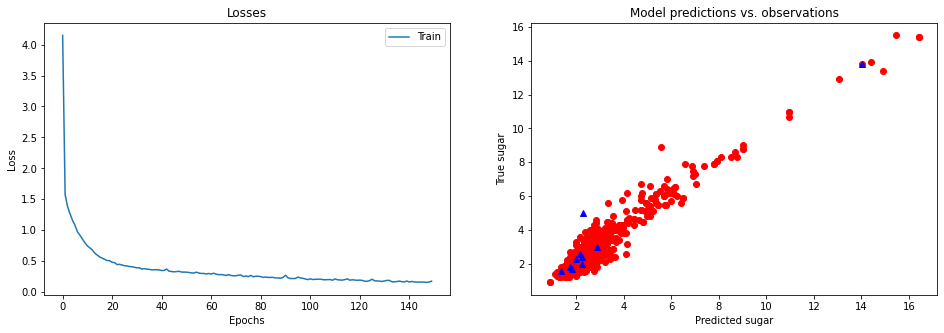

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss, label='Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(train_predict.detach(), y_train, 'ro')
ax[1].plot(test_predict.detach(), y_test, 'b^')
ax[1].set_xlabel('Predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')